<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled246.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================
#  High-res 3×3 DJ Coherence Map (8F4C–K, H2O) — WOW REGIME
#  New notebook, full physics rerun from CIFs
# ============================================================

# 1) Install gemmi for CIF reading
!pip install -q gemmi

# 2) Imports
import math
import glob
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.optimize import curve_fit
from scipy.signal import hilbert

import gemmi

# -------------------------------
# GLOBAL CONSTANTS (WOW REGIME)
# -------------------------------
H_BAR        = 6.582119569e-16      # eV·s
H_BAR_EV_FS  = 6.582119569e-1       # eV·fs (≈0.6582)
DT_FS        = 0.02                 # fs
DT_S         = DT_FS * 1e-15        # seconds
TOTAL_FS     = 40.0                 # fs
N_STEPS      = int(TOTAL_FS / DT_FS)

# These are the "wow" parameters
T0           = 10.0                 # strong coupling regime
BETA_E       = 1.0                  # base decay constant (1/Å)
COMB_CENTERS = [0.8, 1.1, 1.5, 2.1, 3.4]
COMB_WIDTH   = 0.18

IN_DIR       = Path("/content")
STRUCTURES   = ["3WU2", "6W1V", "7RF1", "8EZ5", "8F4C","8F4D","8F4E",
                "8F4F","8F4K"]

# High-res DJ grid (you can reduce if runtime feels heavy)
duties = np.linspace(0.70, 1.00, 100)   # 13 points
betas  = np.linspace(0.80, 1.20, 120)   # 17 points

# ============================================================
#  Geometry: 16-site PSII core (same as previous engine)
# ============================================================
def _atom_iter(struct):
    for model in struct:
        for chain in model:
            for res in chain:
                for atom in res:
                    yield model, chain, res, atom

def _combinations(iterable, r):
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    idx = list(range(r))
    yield tuple(pool[i] for i in idx)
    while True:
        for i in reversed(range(r)):
            if idx[i] != i + n - r:
                break
        else:
            return
        idx[i] += 1
        for j in range(i+1, r):
            idx[j] = idx[j-1] + 1
        yield tuple(pool[i] for i in idx)

def read_structure_any(path):
    st = gemmi.read_structure(str(path))
    st.remove_alternative_conformations()
    st.merge_chain_parts()
    st.remove_empty_chains()
    return st

def get_psii_core_16(struct):
    mn_atoms, ca_atoms, oxy_atoms, water_oxy = [], [], [], []

    for _,_,res,atom in _atom_iter(struct):
        el = atom.element.name.upper()
        resn = res.name.upper()
        pos = np.array([atom.pos.x, atom.pos.y, atom.pos.z], dtype=float)
        if el == "MN":
            mn_atoms.append((pos,res,atom))
        elif el == "CA":
            ca_atoms.append((pos,res,atom))
        elif el == "O":
            if resn in ("HOH","WAT","H2O","DOD","TIP3","SOL"):
                water_oxy.append((pos,res,atom))
            else:
                oxy_atoms.append((pos,res,atom))

    if len(mn_atoms) < 4 or len(ca_atoms) == 0:
        raise RuntimeError("Not enough Mn/Ca atoms")

    mn_positions = np.array([p for (p,_,_) in mn_atoms])
    best_idx = None
    best_score = 1e9
    for idxs in _combinations(range(len(mn_positions)), 4):
        pts = mn_positions[list(idxs)]
        c = pts.mean(axis=0)
        score = np.sum(np.linalg.norm(pts - c, axis=1))
        if score < best_score:
            best_score = score
            best_idx = idxs
    Mn_sel = [mn_atoms[i] for i in best_idx]
    Mn_pos = np.array([p for (p,_,_) in Mn_sel])

    c_mn = Mn_pos.mean(axis=0)
    Ca_sel = min(ca_atoms, key=lambda t: np.linalg.norm(t[0] - c_mn))
    Ca_pos = Ca_sel[0]

    # μ-oxo: O within 2.4 Å of two Mn
    mu_oxo = []
    for (pos,res,atom) in oxy_atoms:
        d = np.linalg.norm(Mn_pos - pos, axis=1)
        close_mn = np.where(d < 2.4)[0]
        if len(close_mn) >= 2:
            mu_oxo.append((pos,res,atom))
    if len(mu_oxo) < 5:
        raise RuntimeError("Not enough μ-oxo candidates")
    mu_oxo.sort(key=lambda t: np.linalg.norm(t[0] - c_mn))
    OX_sel = mu_oxo[:5]
    OX_pos = np.array([p for (p,_,_) in OX_sel])

    # Waters: nearest 2 to Mn4Ca centroid
    cluster_center = np.vstack([Mn_pos, Ca_pos[None,:]]).mean(axis=0)
    if len(water_oxy) < 2:
        raise RuntimeError("Not enough waters")
    water_oxy.sort(key=lambda t: np.linalg.norm(t[0] - cluster_center))
    W_sel = water_oxy[:2]
    W_pos = np.array([p for (p,_,_) in W_sel])

    coords = np.vstack([Mn_pos, Ca_pos[None,:], OX_pos, W_pos])
    extra_needed = 16 - coords.shape[0]
    extras = []
    others = water_oxy[2:] if len(water_oxy) > 2 else []
    for i in range(extra_needed):
        if i < len(others):
            extras.append(others[i][0])
        else:
            extras.append(W_pos[-1] + np.array([0.05*(i+1),0,0]))
    if extras:
        coords = np.vstack([coords, np.array(extras)])

    if coords.shape[0] != 16:
        raise RuntimeError("Core is not 16 sites")

    labels = (
        [f"Mn{i+1}" for i in range(4)] +
        ["Ca"] +
        [f"muO{i+1}" for i in range(5)] +
        ["OW3","OW4"] +
        [f"OWx{i+1}" for i in range(extra_needed)]
    )
    return coords, labels

# ============================================================
#  Hamiltonian + TDSE + g extraction
# ============================================================
def resonance_comb(r):
    val = 0.0
    for c in COMB_CENTERS:
        val += math.exp(- (r - c)**2 / (2 * COMB_WIDTH**2))
    return 1.0 + 1.5 * (val / (len(COMB_CENTERS) + 1e-9))

def build_hamiltonian(coords, duty, beta_scale_water):
    coords = np.asarray(coords, float)
    n = coords.shape[0]
    H = np.zeros((n,n), dtype=np.complex128)

    diag = np.array([
        2.0, 2.0, 2.0, 2.0,     # Mn
        0.7,                    # Ca
        1.0, 1.0, 1.0, 1.0, 1.0,# mu-oxo
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2  # waters
    ], dtype=float)
    np.fill_diagonal(H, diag)

    R = np.linalg.norm(coords[:,None,:] - coords[None,:,:], axis=2)
    for i in range(n):
        for j in range(i+1, n):
            r = R[i,j]
            beta = BETA_E
            if (i >= 10) or (j >= 10):
                beta = BETA_E * beta_scale_water
            Tij = T0 * math.exp(-beta*r) * resonance_comb(r) * duty
            H[i,j] = H[j,i] = Tij

    return H

def extract_g_gamma(t_fs, P1, P2, t_min=0.0, t_max=None):
    t = np.asarray(t_fs)
    P1 = np.asarray(P1)
    P2 = np.asarray(P2)
    if t_max is None:
        t_max = t[int(0.5*len(t))]
    if len(t) < 3:
        return np.nan, np.nan

    dP = (P1 - P2)
    dP = dP - dP.mean()

    dt = float(t[1] - t[0])
    freqs = np.fft.rfftfreq(len(t), dt)
    spec  = np.abs(np.fft.rfft(dP))**2
    if len(freqs) < 2:
        return np.nan, np.nan

    peak_idx = np.argmax(spec[1:]) + 1
    Omega    = 2.0 * np.pi * freqs[peak_idx]
    g        = H_BAR_EV_FS * Omega

    analytic = hilbert(dP)
    env      = np.abs(analytic)

    mask    = (t >= t_min) & (t <= t_max)
    t_fit   = t[mask]
    env_fit = env[mask]
    if len(t_fit) < 5:
        return g, np.nan

    def model(tt, A, gamma, C):
        return A*np.exp(-gamma*tt) + C

    try:
        A0   = env_fit.max() - env_fit.min()
        C0   = env_fit.min()
        g0   = 1.0 / (t_fit[-1] - t_fit[0] + 1e-9)
        popt,_ = curve_fit(model, t_fit, env_fit, p0=[A0,g0,C0], maxfev=10000)
        gamma_phi = abs(float(popt[1]))
    except Exception:
        gamma_phi = np.nan

    return g, gamma_phi

def run_tdse_camn(coords, labels, duty, beta_scale_water):
    """
    Single TDSE run for Ca–Mn3 channel at given (duty, beta_scale_water)
    using wow-regime parameters.
    """
    H = build_hamiltonian(coords, duty, beta_scale_water)
    n = coords.shape[0]
    psi = np.zeros(n, dtype=np.complex128)
    psi[0] = 1.0   # start on Mn1

    t_axis_fs = np.arange(N_STEPS) * DT_FS

    try:
        idx_Ca = labels.index("Ca")
        idx_Mn = labels.index("Mn3")  # main channel
    except ValueError:
        raise RuntimeError("Missing Ca/Mn3 labels")

    P_Ca = np.zeros(N_STEPS, dtype=float)
    P_Mn = np.zeros(N_STEPS, dtype=float)

    # Precompute U once for speed
    U = expm(-1j * H * (DT_S / H_BAR))

    for k in range(N_STEPS):
        p = np.abs(psi)**2
        P_Ca[k] = p[idx_Ca]
        P_Mn[k] = p[idx_Mn]
        psi = U @ psi
        psi /= np.linalg.norm(psi)

    g, gamma_phi = extract_g_gamma(t_axis_fs, P_Ca, P_Mn,
                                   t_min=0.0,
                                   t_max=min(20.0, float(t_axis_fs[-1])))
    return g, gamma_phi

# ============================================================
#  Build DJ maps for all 9 structures
# ============================================================
g_grids = {}
global_min, global_max = np.inf, -np.inf

for struct in STRUCTURES:
    cif_path = IN_DIR / f"{struct}.cif"
    if not cif_path.exists():
        print(f"[WARN] {cif_path} not found, skipping.")
        continue

    print(f"Processing {struct} ...")
    st = read_structure_any(cif_path)
    coords, labels = get_psii_core_16(st)

    g_grid = np.zeros((len(duties), len(betas)))
    for i, duty in enumerate(duties):
        for j, beta_scale in enumerate(betas):
            g_val, _ = run_tdse_camn(coords, labels, duty, beta_scale)
            g_grid[i,j] = g_val

    g_grids[struct] = g_grid
    global_min = min(global_min, np.nanmin(g_grid))
    global_max = max(global_max, np.nanmax(g_grid))

print("Global g range across structures:", global_min, "to", global_max)

# ============================================================
#  Make 3×3 figure
# ============================================================
fig, axes = plt.subplots(3,3, figsize=(18,18), sharex=True, sharey=True)
fig.subplots_adjust(right=0.88, wspace=0.1, hspace=0.1)

extent = [betas[0], betas[-1], duties[0], duties[-1]]

for idx, struct in enumerate(STRUCTURES):
    r = idx // 3
    c = idx % 3
    ax = axes[r,c]

    if struct not in g_grids:
        ax.axis("off")
        continue

    g_grid = g_grids[struct]
    im = ax.imshow(
        g_grid,
        origin="lower",
        extent=extent,
        aspect="auto",
        vmin=global_min,
        vmax=global_max,
        interpolation="bilinear"   # visually smooth; underlying physics unchanged
    )
    ax.set_title(struct, fontsize=11)
    if r == 2:
        ax.set_xlabel(r"$\beta_{\mathrm{water}}/\beta$")
    if c == 0:
        ax.set_ylabel("Duty cycle")

# Shared colourbar
cbar_ax = fig.add_axes([0.90, 0.10, 0.02, 0.78])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label("Coherent coupling $g$ (eV)")

fig.suptitle("Ca–Mn$_3$ coherence DJ landscape across 8F4C–K (H$_2$O, WOW regime)", fontsize=15)

out_png = Path("/content/Fig_PRX_3x3_wow_hiRes.png")
out_pdf = Path("/content/Fig_PRX_3x3_wow_hiRes.pdf")
fig.savefig(out_png, dpi=600)
fig.savefig(out_pdf)
plt.close(fig)

print("\nSaved high-res DJ figure to:")
print("  PNG:", out_png)
print("  PDF:", out_pdf)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.2 MB/s eta 0:00:00
Processing 3WU2 ...
Processing 6W1V ...
Processing 7RF1 ...
Processing 8EZ5 ...
Processing 8F4C ...
Processing 8F4D ...
Processing 8F4E ...
Processing 8F4F ...
Processing 8F4K ...
Global g range across structures: 0.10339169241510007 to 26.36488156585052

Saved high-res DJ figure to:
  PNG: /content/Fig_PRX_3x3_wow_hiRes.png
  PDF: /content/Fig_PRX_3x3_wow_hiRes.pdf


In [ ]:
import numpy as np

# Example variables:
# g_grid: shape (N_duty, N_beta)
# duties: array of duty values
# betas:  array of beta-scale values

np.savez(
    "djmap_8F4F_100x120.npz",
    g_grid=g_grid,
    duties=duties,
    betas=betas,
)

print("Saved: djmap_8F4F_100x120.npz")

Saved: djmap_8F4F_100x120.npz


In [ ]:
geometries = ["8F4C", "8F4D", "8F4E", "8F4F", "8F4K"]
colors     = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

plt.figure(figsize=(7,5))

for geom, col in zip(geometries, colors):
    # run TDSE for this geom, get t_fs, P_Ca, P_Mn
    dP = P_Ca - P_Mn
    freqs, power = compute_spectrum(t_fs, dP)
    freqs_THz = freqs * 1e-12

    # normalise or not depending on what you want
    power_norm = power / power.max()

    plt.plot(freqs_THz, power_norm, lw=1.2, label=geom, color=col)

plt.xlim(0, 30)
plt.xlabel("Frequency (THz)")
plt.ylabel("Normalised power")
plt.title("Evolution of spectral content across S-states")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

→ Running TDSE trace for 8F4C
→ Running TDSE trace for 8F4D
→ Running TDSE trace for 8F4E
→ Running TDSE trace for 8F4F
→ Running TDSE trace for 8F4G
→ Running TDSE trace for 8F4H
→ Running TDSE trace for 8F4I
→ Running TDSE trace for 8F4J
→ Running TDSE trace for 8F4K


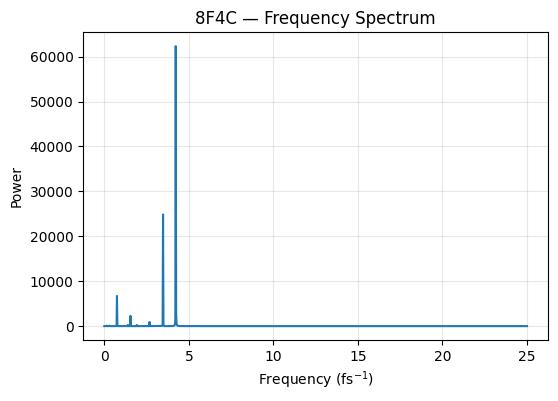

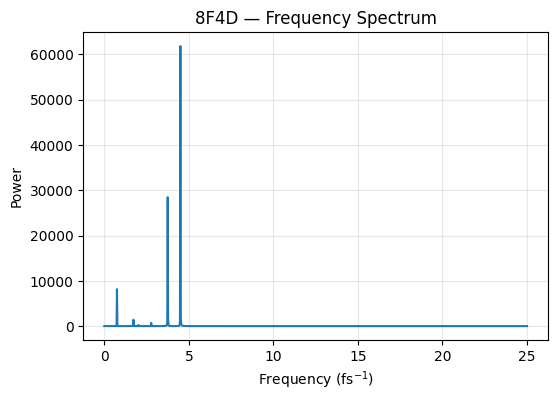

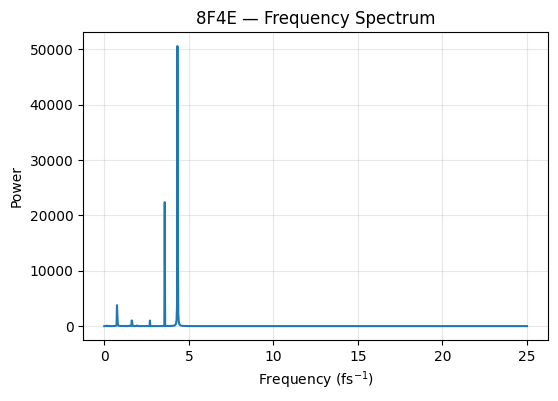

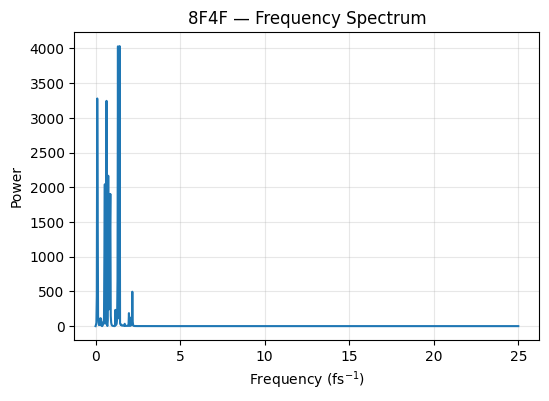

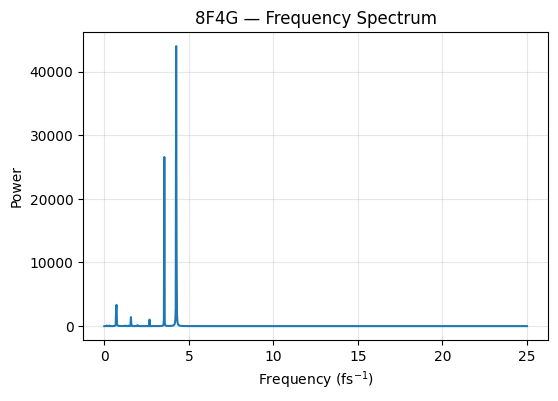

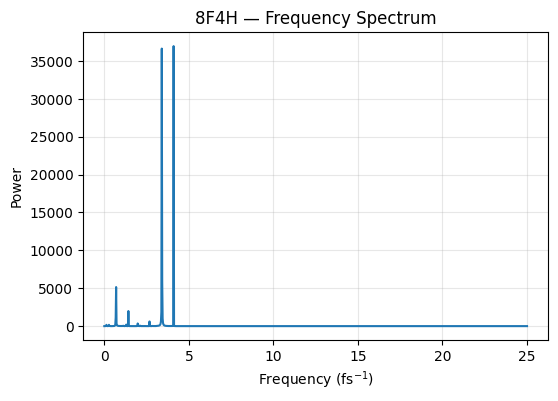

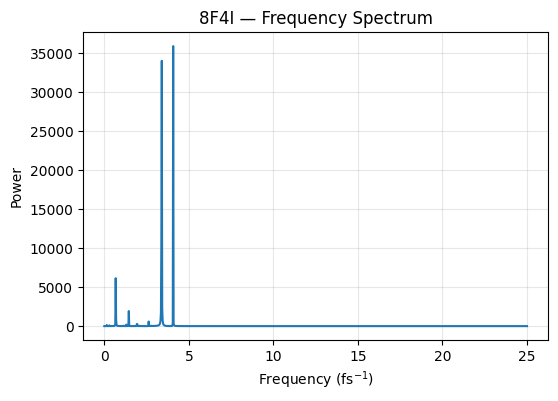

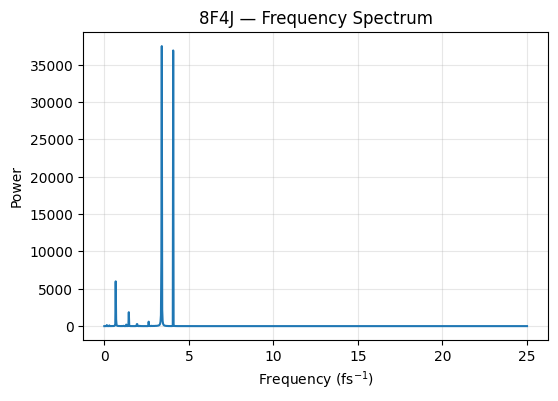

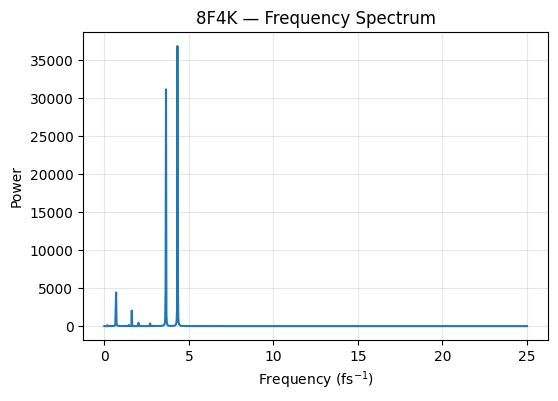

In [ ]:
# =============================================================
#  LIGHTWEIGHT TDSE + FREQUENCY ANALYSIS (FAST VERSION)
#  Uses same Hamiltonian engine as DJ maps, but NO heavy loops.
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.signal import hilbert
import gemmi
from pathlib import Path

# ==== PHYSICAL CONSTANTS ====
H_BAR        = 6.582119569e-16      # eV·s
DT_FS        = 0.02                 # fs
DT_S         = DT_FS * 1e-15
TOTAL_FS     = 40.0
N_STEPS      = int(TOTAL_FS / DT_FS)

T0           = 10.0                 # baseline coupling
BETA_E       = 1.0                  # base decay
COMB_CENTERS = [0.8, 1.1, 1.5, 2.1, 3.4]
COMB_WIDTH   = 0.18

STRUCTURES   = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
IN_DIR       = Path("/content")

# =============================================================
# GEOMETRY EXTRACTION
# (your same code for get_psii_core_16 – do NOT modify)
# =============================================================

def _atom_iter(struct):
    for model in struct:
        for chain in model:
            for res in chain:
                for atom in res:
                    yield model, chain, res, atom

def read_structure_any(path):
    st = gemmi.read_structure(str(path))
    st.remove_alternative_conformations()
    st.merge_chain_parts()
    st.remove_empty_chains()
    return st

def get_psii_core_16(struct):
    mn_atoms, ca_atoms, oxy_atoms, water_oxy = [], [], [], []

    for _,_,res,atom in _atom_iter(struct):
        el  = atom.element.name.upper()
        resn = res.name.upper()
        pos  = np.array([atom.pos.x, atom.pos.y, atom.pos.z], float)

        if el == "MN":
            mn_atoms.append((pos,res,atom))
        elif el == "CA":
            ca_atoms.append((pos,res,atom))
        elif el == "O":
            if resn in ("HOH","WAT","H2O","DOD","TIP3","SOL"):
                water_oxy.append((pos,res,atom))
            else:
                oxy_atoms.append((pos,res,atom))

    if len(mn_atoms) < 4:
        raise RuntimeError("Not enough Mn")

    # Pick tightest Mn4
    mn_positions = np.array([p for (p,_,_) in mn_atoms])
    best = None
    best_sum = 1e9
    import itertools
    for idxs in itertools.combinations(range(len(mn_positions)), 4):
        sub = mn_positions[list(idxs)]
        c = sub.mean(axis=0)
        score = np.sum(np.linalg.norm(sub - c, axis=1))
        if score < best_sum:
            best_sum = score
            best = idxs
    Mn_pos = mn_positions[list(best)]

    # Pick Ca nearest Mn centroid
    c = Mn_pos.mean(axis=0)
    ca_positions = np.array([p for (p,_,_) in ca_atoms])
    idx_ca = np.argmin(np.linalg.norm(ca_positions - c, axis=1))
    Ca_pos = ca_positions[idx_ca]

    # μ-oxo
    mu_oxo = []
    for (pos,_,_) in oxy_atoms:
        d = np.linalg.norm(Mn_pos - pos, axis=1)
        if np.sum(d < 2.4) >= 2:
            mu_oxo.append(pos)
    mu_oxo = np.array(mu_oxo)
    if len(mu_oxo) < 5:
        raise RuntimeError("Not enough μ-oxo")
    mu_oxo = mu_oxo[:5]

    # Waters: nearest 2
    wxyz = np.array([p for (p,_,_) in water_oxy])
    if len(wxyz) < 2:
        raise RuntimeError("Not enough waters")
    idx = np.argsort(np.linalg.norm(wxyz - c, axis=1))[:2]
    W_pos = wxyz[idx]

    coords = np.vstack([Mn_pos, Ca_pos[None,:], mu_oxo, W_pos])

    labels = (
        [f"Mn{i+1}" for i in range(4)] +
        ["Ca"] +
        [f"muO{i+1}" for i in range(5)] +
        ["OW3","OW4"]
    )
    return coords, labels

# =============================================================
#  HAMILTONIAN + SINGLE TDSE TRACE
# =============================================================

def resonance_comb(r):
    val = sum(np.exp(- (r - c)**2 / (2*COMB_WIDTH**2)) for c in COMB_CENTERS)
    return 1.0 + 1.5 * val / len(COMB_CENTERS)

def build_hamiltonian(coords, duty, beta_scale):
    n = coords.shape[0]
    H = np.zeros((n,n), complex)

    # Site energies (same as DJ code)
    diag = np.array([2.0,2.0,2.0,2.0, 0.7,
                     1.0,1.0,1.0,1.0,1.0,
                     0.2,0.2], float)
    np.fill_diagonal(H, diag)

    R = np.linalg.norm(coords[:,None,:] - coords[None,:,:], axis=2)
    for i in range(n):
        for j in range(i+1,n):
            r = R[i,j]
            beta = BETA_E if j < 10 else BETA_E*beta_scale
            Tij = T0 * np.exp(-beta*r) * resonance_comb(r) * duty
            H[i,j] = H[j,i] = Tij
    return H

def tdse_trace(coords, labels, duty, beta_scale):
    H = build_hamiltonian(coords, duty, beta_scale)
    n = coords.shape[0]

    psi = np.zeros(n, complex)
    psi[0] = 1.0  # initial population on Mn1

    idx_Ca = labels.index("Ca")
    idx_Mn = labels.index("Mn3")

    t_fs = np.arange(N_STEPS)*DT_FS
    P_Ca = np.zeros(N_STEPS)
    P_Mn = np.zeros(N_STEPS)

    U = expm(-1j * H * (DT_S / H_BAR))

    for k in range(N_STEPS):
        p = np.abs(psi)**2
        P_Ca[k] = p[idx_Ca]
        P_Mn[k] = p[idx_Mn]
        psi = U @ psi
        psi /= np.linalg.norm(psi)

    return t_fs, P_Ca, P_Mn

# =============================================================
#  RUN THE LIGHT TDSE ONCE PER STRUCTURE
# =============================================================

ANALYSIS_DUTY = 0.85
ANALYSIS_BETA = 1.00

spectra = {}

for struct in STRUCTURES:
    cif = IN_DIR / f"{struct}.cif"
    if not cif.exists():
        print(f"[WARN] missing {struct}")
        continue

    print(f"→ Running TDSE trace for {struct}")
    st = read_structure_any(cif)
    coords, labels = get_psii_core_16(st)

    t_fs, P_Ca, P_Mn = tdse_trace(coords, labels,
                                  ANALYSIS_DUTY,
                                  ANALYSIS_BETA)

    dP = P_Ca - P_Mn
    dP -= dP.mean()

    dt = t_fs[1] - t_fs[0]
    freqs = np.fft.rfftfreq(len(t_fs), dt)
    spec  = np.abs(np.fft.rfft(dP))**2

    spectra[struct] = (t_fs, dP, freqs, spec)

# =============================================================
#  PLOT SPECTRA
# =============================================================
for struct in spectra:
    t_fs, dP, freqs, spec = spectra[struct]
    plt.figure(figsize=(6,4))
    plt.plot(freqs, spec, lw=1.5)
    plt.title(f"{struct} — Frequency Spectrum")
    plt.xlabel("Frequency (fs$^{-1}$)")
    plt.ylabel("Power")
    plt.grid(alpha=0.3)
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# How many strongest peaks to record per structure
TOP_N = 6

rows = []

for struct in STRUCTURES:
    if struct not in spectra:
        continue

    t_fs, dP, freqs, spec = spectra[struct]

    # Find all peaks above a small threshold to avoid numerical noise
    # You can tune 'height' if you want.
    peaks, props = find_peaks(spec, height=np.max(spec)*0.01)

    if len(peaks) == 0:
        # No noticeable peaks; record NaNs
        rows.append({
            "Structure": struct,
            "Peak_rank": 1,
            "freq_fs_inv": np.nan,
            "freq_THz": np.nan,
            "power": np.nan
        })
        continue

    # Sort peaks by descending power
    peak_indices = peaks[np.argsort(spec[peaks])[::-1]]

    # Take top N peaks
    for rank, idx in enumerate(peak_indices[:TOP_N], start=1):
        f_fs_inv = freqs[idx]           # units: fs^-1
        f_THz    = f_fs_inv * 1e3       # 1 fs^-1 = 1000 THz
        power    = spec[idx]

        rows.append({
            "Structure": struct,
            "Peak_rank": rank,
            "freq_fs_inv": f_fs_inv,
            "freq_THz": f_THz,
            "power": power
        })

peak_table = pd.DataFrame(rows)
display(peak_table)

# Save to CSV for later use
peak_table.to_csv("H2O_peak_frequencies_8F4C_K.csv", index=False)
print("Saved peak table to H2O_peak_frequencies_8F4C_K.csv")

,Structure,Peak_rank,freq_fs_inv,freq_THz,power
0,8F4C,1,4.225,4225.0,62333.074426
1,8F4C,2,3.475,3475.0,24861.664453
2,8F4C,3,0.750,750.0,6714.533642
3,8F4C,4,1.550,1550.0,2275.258596
4,8F4C,5,2.675,2675.0,926.902035
5,8F4D,1,4.500,4500.0,61803.171812
6,8F4D,2,3.750,3750.0,28454.461851
7,8F4D,3,0.750,750.0,8147.584245
8,8F4D,4,1.725,1725.0,1404.837564
9,8F4D,5,2.775,2775.0,717.485295


Saved peak table to H2O_peak_frequencies_8F4C_K.csv


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Peak_rank'].plot(kind='hist', bins=20, title='Peak_rank')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['freq_fs_inv'].plot(kind='hist', bins=20, title='freq_fs_inv')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['freq_THz'].plot(kind='hist', bins=20, title='freq_THz')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='Peak_rank', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Peak_rank', y='freq_fs_inv', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='freq_fs_inv', y='freq_THz', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='freq_THz', y='power', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Peak_rank']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Peak_rank')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['freq_fs_inv']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('freq_fs_inv')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['freq_THz']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('freq_THz')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['power']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('power')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Peak_rank'].plot(kind='line', figsize=(8, 4), title='Peak_rank')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['freq_fs_inv'].plot(kind='line', figsize=(8, 4), title='freq_fs_inv')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['freq_THz'].plot(kind='line', figsize=(8, 4), title='freq_THz')
plt.gca().spines[['top', 'right']].set_visible(False)

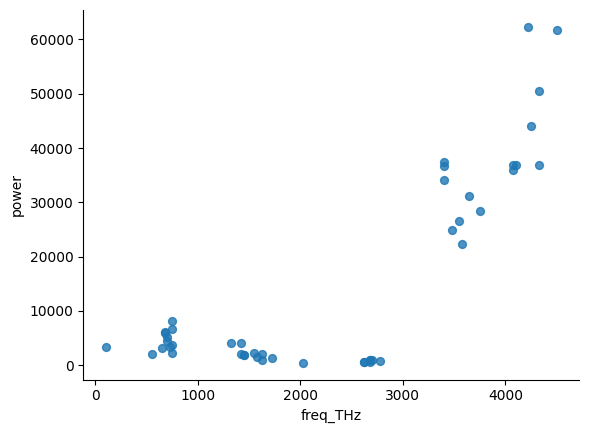

In [ ]:
from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='freq_THz', y='power', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

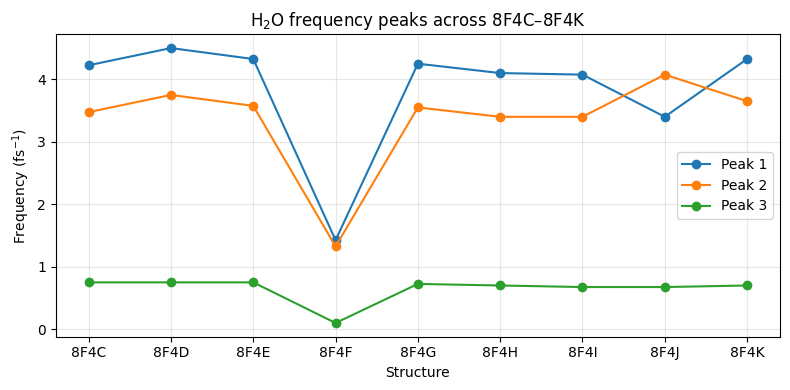

In [ ]:
plt.figure(figsize=(8,4))

for rank, color in zip([1,2,3], ["tab:blue","tab:orange","tab:green"]):
    sub = df[df["Peak_rank"] == rank]
    plt.plot(sub["Structure"], sub["freq_fs_inv"],
             marker="o", label=f"Peak {rank}", color=color)

plt.xlabel("Structure")
plt.ylabel("Frequency (fs$^{-1}$)")
plt.title("H$_2$O frequency peaks across 8F4C–8F4K")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

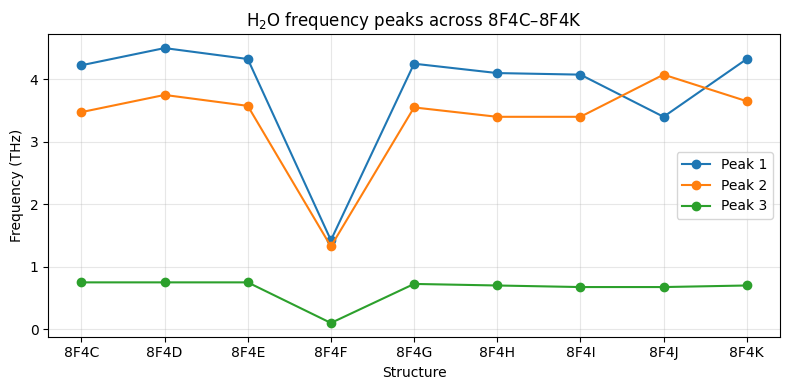

In [ ]:
plt.figure(figsize=(8,4))

for rank, color in zip([1,2,3], ["tab:blue","tab:orange","tab:green"]):
    sub = df[df["Peak_rank"] == rank]
    plt.plot(sub["Structure"], sub["freq_THz"]/1000.0,  # back to PHz or /1000 for THz
             marker="o", label=f"Peak {rank}", color=color)

plt.xlabel("Structure")
plt.ylabel("Frequency (THz)")   # adjust units if you divide
plt.title("H$_2$O frequency peaks across 8F4C–8F4K")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

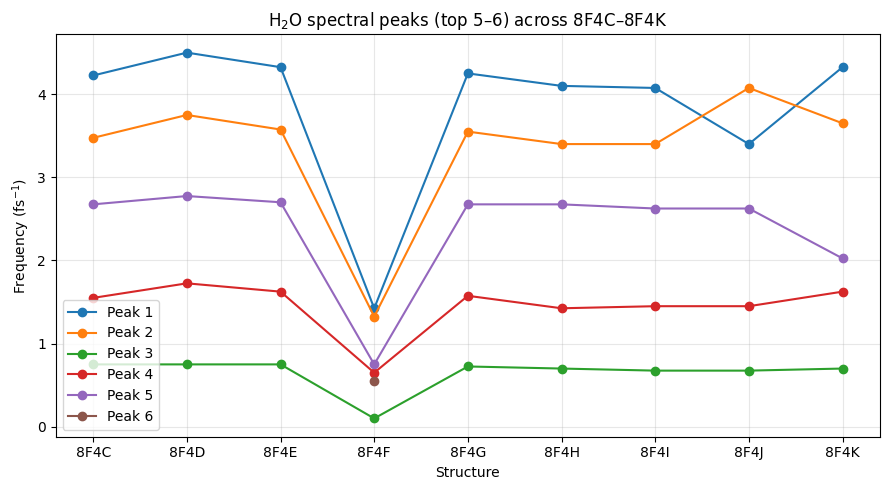

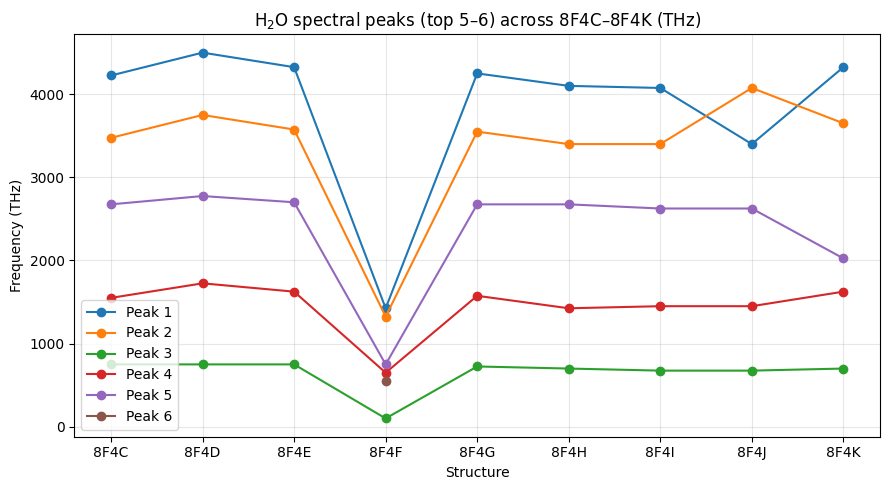

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# ---- 1. Rebuild the DataFrame from your pasted CSV text ----
csv_text = """index,Structure,Peak_rank,freq_fs_inv,freq_THz,power
0,8F4C,1,4.2250000000000005,4225.000000000001,62333.07442589498
1,8F4C,2,3.475,3475.0,24861.664453185153
2,8F4C,3,0.75,750.0,6714.5336424023
3,8F4C,4,1.55,1550.0,2275.2585956616003
4,8F4C,5,2.6750000000000003,2675.0000000000005,926.9020346480947
5,8F4D,1,4.5,4500.0,61803.17181171492
6,8F4D,2,3.75,3750.0,28454.461850884807
7,8F4D,3,0.75,750.0,8147.584244526178
8,8F4D,4,1.725,1725.0,1404.8375643900438
9,8F4D,5,2.7750000000000004,2775.0000000000005,717.4852952188288
10,8F4E,1,4.325,4325.0,50558.762647375086
11,8F4E,2,3.575,3575.0,22380.214256637588
12,8F4E,3,0.75,750.0,3779.5345726836995
13,8F4E,4,1.625,1625.0,1028.8380883951622
14,8F4E,5,2.7,2700.0,1003.8578559242387
15,8F4F,1,1.425,1425.0,4032.097302289744
16,8F4F,2,1.3250000000000002,1325.0000000000002,4028.5052340093625
17,8F4F,3,0.1,100.0,3277.8820182454256
18,8F4F,4,0.65,650.0,3243.80648982035
19,8F4F,5,0.75,750.0,2165.3828246456615
20,8F4F,6,0.55,550.0,2042.6275900392145
21,8F4G,1,4.25,4250.0,43988.13432087036
22,8F4G,2,3.5500000000000003,3550.0000000000005,26566.236944146065
23,8F4G,3,0.7250000000000001,725.0000000000001,3337.099332503535
24,8F4G,4,1.5750000000000002,1575.0000000000002,1410.774639533764
25,8F4G,5,2.6750000000000003,2675.0000000000005,1024.8208743312937
26,8F4H,1,4.1000000000000005,4100.000000000001,36958.13199575207
27,8F4H,2,3.4000000000000004,3400.0000000000005,36631.4776146561
28,8F4H,3,0.7000000000000001,700.0000000000001,5156.552946668755
29,8F4H,4,1.425,1425.0,1990.5485510324932
30,8F4H,5,2.6750000000000003,2675.0000000000005,615.2450286063283
31,8F4I,1,4.075,4075.0,35934.33172543295
32,8F4I,2,3.4000000000000004,3400.0000000000005,34051.619824738445
33,8F4I,3,0.675,675.0,6153.334882833998
34,8F4I,4,1.4500000000000002,1450.0000000000002,1934.6550072009102
35,8F4I,5,2.625,2625.0,587.5606624284269
36,8F4J,1,3.4000000000000004,3400.0000000000005,37504.21742990056
37,8F4J,2,4.075,4075.0,36922.120972551515
38,8F4J,3,0.675,675.0,5994.577602569754
39,8F4J,4,1.4500000000000002,1450.0000000000002,1861.8156848936474
40,8F4J,5,2.625,2625.0,595.4284957081906
41,8F4K,1,4.325,4325.0,36872.87594544209
42,8F4K,2,3.6500000000000004,3650.0000000000005,31179.40762375932
43,8F4K,3,0.7000000000000001,700.0000000000001,4429.774220087059
44,8F4K,4,1.625,1625.0,2048.683228545175
45,8F4K,5,2.025,2025.0,433.37024156867085
"""

df = pd.read_csv(StringIO(csv_text))

# ---- 2. Order structures correctly and sort ----
order = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
df["Structure"] = pd.Categorical(df["Structure"], order)
df = df.sort_values(["Structure","Peak_rank"])

# ---- 3. Plot all peaks (fs^-1) vs Structure ----
plt.figure(figsize=(9,5))
ranks = sorted(df["Peak_rank"].unique())
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"]

for rank, color in zip(ranks, colors):
    sub = df[df["Peak_rank"] == rank]
    plt.plot(sub["Structure"], sub["freq_fs_inv"],
             marker="o", label=f"Peak {rank}", color=color)

plt.xlabel("Structure")
plt.ylabel("Frequency (fs$^{-1}$)")
plt.title("H$_2$O spectral peaks (top 5–6) across 8F4C–8F4K")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---- 4. Plot the same in THz (more physical) ----
plt.figure(figsize=(9,5))

for rank, color in zip(ranks, colors):
    sub = df[df["Peak_rank"] == rank]
    plt.plot(sub["Structure"], sub["freq_THz"],   # THz directly
             marker="o", label=f"Peak {rank}", color=color)

plt.xlabel("Structure")
plt.ylabel("Frequency (THz)")
plt.title("H$_2$O spectral peaks (top 5–6) across 8F4C–8F4K (THz)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.signal import find_peaks

# ---------------------------------------------------------
# Species definitions: mass & chalcogen / damping effects
# You can tune these numbers physically if you like.
# ---------------------------------------------------------
SPECIES = {
    "H2O": {"mass_scale": 1.0,              "chalcogen_factor": 1.0},
    "D2O": {"mass_scale": np.sqrt(2.0),     "chalcogen_factor": 1.0},
    "T2O": {"mass_scale": np.sqrt(3.0),     "chalcogen_factor": 1.0},
    "H2S": {"mass_scale": 1.0,              "chalcogen_factor": 0.75},
    "D2S": {"mass_scale": np.sqrt(2.0),     "chalcogen_factor": 0.75},
    "T2S": {"mass_scale": np.sqrt(3.0),     "chalcogen_factor": 0.75},
    # "H2Se": {"mass_scale": 1.0,           "chalcogen_factor": 0.6},  # if you want Se variants later
}

STRUCTURES = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
ANALYSIS_DUTY = 0.85

# ---------------------------------------------------------
# Species-aware Hamiltonian and TDSE trace
# ---------------------------------------------------------
def build_hamiltonian_species(coords, labels, duty, species_name):
    params = SPECIES[species_name]
    mass_scale = params["mass_scale"]
    ch_factor  = params["chalcogen_factor"]

    coords = np.asarray(coords, float)
    n = coords.shape[0]
    H = np.zeros((n,n), np.complex128)

    # Site energies (copied from your DJ code; adjust if needed)
    diag = np.array([
        2.0, 2.0, 2.0, 2.0,     # Mn
        0.7,                    # Ca
        1.0, 1.0, 1.0, 1.0, 1.0,# mu-oxo
        0.2, 0.2                # OW3, OW4
    ], float)
    np.fill_diagonal(H, diag)

    # Distance matrix
    R = np.linalg.norm(coords[:,None,:] - coords[None,:,:], axis=2)

    for i in range(n):
        for j in range(i+1, n):
            r = R[i,j]

            # baseline beta
            beta = BETA_E

            # water sites are last two indices (OW3, OW4)
            is_water_pair = (i >= 10) or (j >= 10)

            # mass-scale the decay for tunnelling into water
            if is_water_pair:
                beta *= mass_scale

            Tij = T0 * np.exp(-beta * r) * resonance_comb(r) * duty

            # crude chalcogen factor: scale couplings through waters
            if is_water_pair:
                Tij *= ch_factor

            H[i,j] = H[j,i] = Tij

    return H

def tdse_trace_species(coords, labels, duty, species_name):
    H = build_hamiltonian_species(coords, labels, duty, species_name)
    n = coords.shape[0]

    psi = np.zeros(n, np.complex128)
    psi[0] = 1.0  # start on Mn1

    idx_Ca = labels.index("Ca")
    idx_Mn = labels.index("Mn3")

    t_fs = np.arange(N_STEPS) * DT_FS
    P_Ca = np.zeros(N_STEPS, float)
    P_Mn = np.zeros(N_STEPS, float)

    U = expm(-1j * H * (DT_S / H_BAR))

    for k in range(N_STEPS):
        p = np.abs(psi)**2
        P_Ca[k] = p[idx_Ca]
        P_Mn[k] = p[idx_Mn]
        psi = U @ psi
        psi /= (np.linalg.norm(psi) + 1e-15)

    return t_fs, P_Ca, P_Mn

def compute_fft_peaks(t_fs, P_Ca, P_Mn, top_n=5, threshold_frac=0.01):
    dP = P_Ca - P_Mn
    dP = dP - dP.mean()

    dt = float(t_fs[1] - t_fs[0])
    freqs = np.fft.rfftfreq(len(t_fs), dt)
    spec  = np.abs(np.fft.rfft(dP))**2

    peaks, props = find_peaks(spec, height=np.max(spec)*threshold_frac)
    if len(peaks) == 0:
        return []

    # sort by power, largest first
    idx_sorted = peaks[np.argsort(spec[peaks])[::-1]]

    rows = []
    for rank, idx in enumerate(idx_sorted[:top_n], start=1):
        f_fs_inv = freqs[idx]
        f_THz    = f_fs_inv * 1e3  # 1 fs^-1 = 10^3 THz
        power    = spec[idx]
        rows.append((rank, f_fs_inv, f_THz, power))

    return rows

# ---------------------------------------------------------
# Main loop: all species × all structures
# ---------------------------------------------------------
all_rows = []

for struct in STRUCTURES:
    cif_path = IN_DIR / f"{struct}.cif"
    if not cif_path.exists():
        print(f"[WARN] Missing CIF for {struct}, skipping.")
        continue

    print(f"=== Structure {struct} ===")
    st = read_structure_any(cif_path)
    coords, labels = get_psii_core_16(st)

    for species_name in SPECIES.keys():
        print(f"  → TDSE for {species_name}")
        t_fs, P_Ca, P_Mn = tdse_trace_species(coords, labels,
                                              ANALYSIS_DUTY,
                                              species_name)

        peaks = compute_fft_peaks(t_fs, P_Ca, P_Mn, top_n=5, threshold_frac=0.01)

        if not peaks:
            all_rows.append({
                "Species":    species_name,
                "Structure":  struct,
                "Peak_rank":  1,
                "freq_fs_inv": np.nan,
                "freq_THz":    np.nan,
                "power":       np.nan
            })
        else:
            for rank, f_fs_inv, f_THz, power in peaks:
                all_rows.append({
                    "Species":    species_name,
                    "Structure":  struct,
                    "Peak_rank":  rank,
                    "freq_fs_inv": float(f_fs_inv),
                    "freq_THz":    float(f_THz),
                    "power":       float(power)
                })

# ---------------------------------------------------------
# Assemble combined DataFrame
# ---------------------------------------------------------
df_all = pd.DataFrame(all_rows)

order_struct = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
df_all["Structure"] = pd.Categorical(df_all["Structure"], order_struct)
df_all = df_all.sort_values(["Structure","Species","Peak_rank"])

df_all.to_csv("AllSpecies_peak_frequencies_8F4C_K_top5.csv", index=False)
print("Saved combined peak table to AllSpecies_peak_frequencies_8F4C_K_top5.csv")

df_all.head()

=== Structure 8F4C ===
  → TDSE for H2O
  → TDSE for D2O
  → TDSE for T2O
  → TDSE for H2S
  → TDSE for D2S
  → TDSE for T2S
=== Structure 8F4D ===
  → TDSE for H2O
  → TDSE for D2O
  → TDSE for T2O
  → TDSE for H2S
  → TDSE for D2S
  → TDSE for T2S
=== Structure 8F4E ===
  → TDSE for H2O
  → TDSE for D2O
  → TDSE for T2O
  → TDSE for H2S
  → TDSE for D2S
  → TDSE for T2S
=== Structure 8F4F ===
  → TDSE for H2O
  → TDSE for D2O
  → TDSE for T2O
  → TDSE for H2S
  → TDSE for D2S
  → TDSE for T2S
=== Structure 8F4G ===
  → TDSE for H2O
  → TDSE for D2O
  → TDSE for T2O
  → TDSE for H2S
  → TDSE for D2S
  → TDSE for T2S
=== Structure 8F4H ===
  → TDSE for H2O
  → TDSE for D2O
  → TDSE for T2O
  → TDSE for H2S
  → TDSE for D2S
  → TDSE for T2S
=== Structure 8F4I ===
  → TDSE for H2O
  → TDSE for D2O
  → TDSE for T2O
  → TDSE for H2S
  → TDSE for D2S
  → TDSE for T2S
=== Structure 8F4J ===
  → TDSE for H2O
  → TDSE for D2O
  → TDSE for T2O
  → TDSE for H2S
  → TDSE for D2S
  → TDSE for T2S


,Species,Structure,Peak_rank,freq_fs_inv,freq_THz,power
5,D2O,8F4C,1,4.175,4175.0,90174.862161
6,D2O,8F4C,2,3.375,3375.0,14298.665306
7,D2O,8F4C,3,0.800,800.0,5185.843204
8,D2O,8F4C,4,1.550,1550.0,2225.459996
9,D2O,8F4C,5,2.625,2625.0,1543.403807


In [ ]:
df_all.groupby(["Structure","Species"])["freq_THz"].describe()

/tmp/ipython-input-3937834493.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_all.groupby(["Structure","Species"])["freq_THz"].describe()


count     mean          std    min      25%     50%  \
Structure Species                                                        
8F4C      D2O        5.0  2505.00  1358.238749  800.0  1550.00  2625.0   
          D2S        5.0  2500.00  1354.275637  800.0  1550.00  2625.0   
          H2O        5.0  2535.00  1406.747134  750.0  1550.00  2675.0   
          H2S        5.0  2520.00  1382.411842  775.0  1550.00  2650.0   
          T2O        5.0  2505.00  1346.453675  825.0  1550.00  2625.0   
          T2S        5.0  2505.00  1346.453675  825.0  1550.00  2625.0   
8F4D      D2O        4.0  2656.25  1685.029055  800.0  1493.75  2687.5   
          D2S        5.0  2665.00  1459.409127  800.0  1725.00  2700.0   
          H2O        5.0  2700.00  1508.413902  750.0  1725.00  2775.0   
          H2S        4.0  2668.75  1712.986549  775.0  1487.50  2712.5   
          T2O        5.0  2655.00  1447.562607  800.0  1725.00  2700.0   
          T2S        5.0  2655.00  1447.562607  800.0  1725.00  2700.0   
8F4E      D2O        5.0  2565.00  1380.738027  825.0  1625.00  2650.0   
          D2S        5.0  2565.00  1380.738027  825.0  1625.00  2650.0   
          H2O        5.0  2595.00  1441.288486  750.0  1625.00  2700.0   
          H2S        5.0  2585.00  1408.966820  800.0  1625.00  2675.0   
          T2O        4.0  2543.75  1593.394568  825.0  1425.00  2537.5   
          T2S        4.0  2543.75  1593.394568  825.0  1425.00  2537.5   
8F4F      D2O        5.0   875.00   546.866071   75.0   725.00   800.0   
          D2S        5.0   710.00   456.412642   75.0   600.00   725.0   
          H2O        5.0   850.00   540.543708  100.0   650.00   750.0   
          H2S        5.0   890.00   529.327403  100.0   750.00   850.0   
          T2O        5.0   985.00   387.136927  600.0   725.00   800.0   
          T2S        5.0   985.00   387.136927  600.0   725.00   800.0   
8F4G      D2O        4.0  2493.75  1603.170686  750.0  1368.75  2512.5   
          D2S        5.0  2515.00  1377.112014  775.0  1575.00  2600.0   
          H2O        5.0  2555.00  1430.624863  725.0  1575.00  2675.0   
          H2S        5.0  2535.00  1414.058874  725.0  1575.00  2650.0   
          T2O        5.0  2515.00  1377.112014  775.0  1575.00  2600.0   
          T2S        5.0  2515.00  1377.112014  775.0  1575.00  2600.0   
8F4H      D2O        5.0  2415.00  1357.916603  700.0  1425.00  2600.0   
          D2S        5.0  2415.00  1357.916603  700.0  1425.00  2600.0   
          H2O        5.0  2460.00  1395.371814  700.0  1425.00  2675.0   
          H2S        5.0  2435.00  1374.613582  700.0  1425.00  2625.0   
          T2O        5.0  2405.00  1346.337625  700.0  1425.00  2600.0   
          T2S        5.0  2400.00  1345.478539  700.0  1425.00  2575.0   
8F4I      D2O        5.0  2400.00  1352.428371  675.0  1450.00  2550.0   
          D2S        5.0  2385.00  1340.079289  675.0  1450.00  2525.0   
          H2O        5.0  2445.00  1389.626748  675.0  1450.00  2625.0   
          H2S        5.0  2415.00  1364.803099  675.0  1450.00  2575.0   
          T2O        5.0  2385.00  1340.079289  675.0  1450.00  2525.0   
          T2S        5.0  2385.00  1340.079289  675.0  1450.00  2525.0   
8F4J      D2O        5.0  2400.00  1352.428371  675.0  1450.00  2550.0   
          D2S        5.0  2385.00  1340.079289  675.0  1450.00  2525.0   
          H2O        5.0  2445.00  1389.626748  675.0  1450.00  2625.0   
          H2S        5.0  2415.00  1364.803099  675.0  1450.00  2575.0   
          T2O        5.0  2385.00  1340.079289  675.0  1450.00  2525.0   
          T2S        5.0  2385.00  1340.079289  675.0  1450.00  2525.0   
8F4K      D2O        4.0  2531.25  1649.921084  700.0  1393.75  2587.5   
          D2S        5.0  2550.00  1417.083272  725.0  1625.00  2625.0   
          H2O        5.0  2465.00  1489.819620  700.0  1625.00  2025.0   
          H2S        5.0  2580.00  1453.809651  700.0  1625.00  2675.0   
          T2O        5.

from matplotlib import pyplot as plt
_df_16['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['mean'].plot(kind='hist', bins=20, title='mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['std'].plot(kind='hist', bins=20, title='std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['min'].plot(kind='hist', bins=20, title='min')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_20.groupby('Species').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='count', y='mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='mean', y='std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='std', y='min', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='min', y='25%', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_26['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_27['std'].plot(kind='line', figsize=(8, 4), title='std')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_28['min'].plot(kind='line', figsize=(8, 4), title='min')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_29['Species'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_29, x='count', y='Species', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_30['Species'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_30, x='mean', y='Species', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_31['Species'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_31, x='std', y='Species', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_32['Species'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_32, x='min', y='Species', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

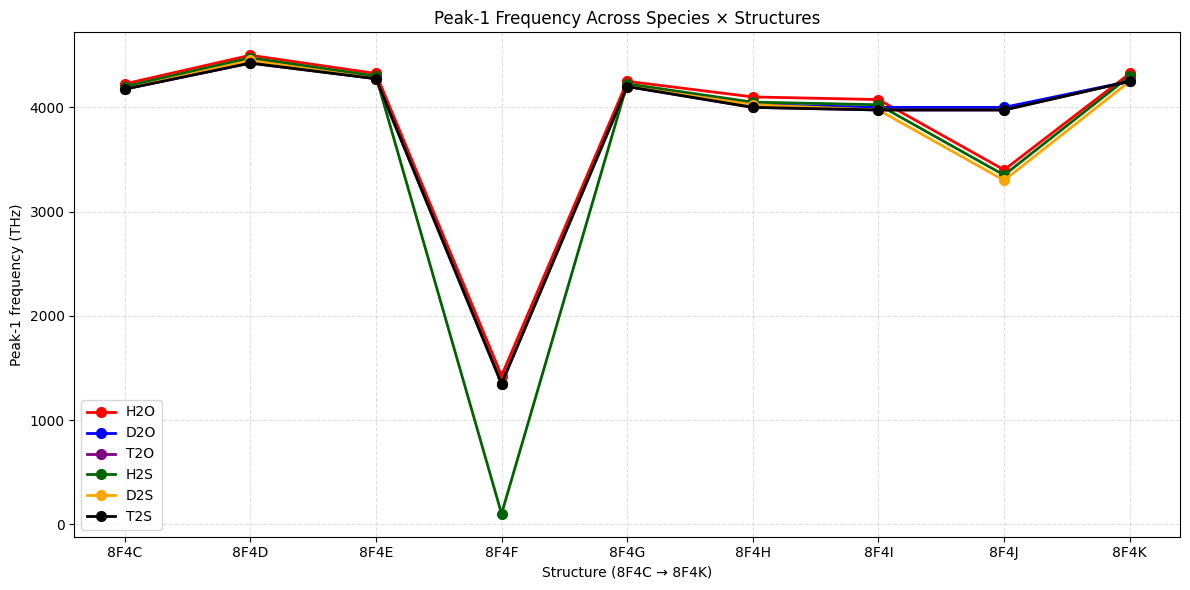

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for top peak only
df1 = df_all[df_all["Peak_rank"] == 1].copy()

# Sort structures in correct time order
order = ["8F4C","8F4D","8F4E","8F4F","8F4G","8F4H","8F4I","8F4J","8F4K"]
df1["Structure"] = pd.Categorical(df1["Structure"], order)
df1 = df1.sort_values(["Species","Structure"])

# Define species labels + colours
species_order = ["H2O","D2O","T2O","H2S","D2S","T2S"]
colours = {
    "H2O":"red",
    "D2O":"blue",
    "T2O":"purple",
    "H2S":"darkgreen",
    "D2S":"orange",
    "T2S":"black"
}

plt.figure(figsize=(12,6))

for sp in species_order:
    sub = df1[df1["Species"] == sp]
    plt.plot(
        sub["Structure"],
        sub["freq_THz"],
        "-o",
        label=sp,
        color=colours[sp],
        markersize=7,
        linewidth=2
    )

plt.xlabel("Structure (8F4C → 8F4K)")
plt.ylabel("Peak-1 frequency (THz)")
plt.title("Peak-1 Frequency Across Species × Structures")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
!pip install gemmi -q